#### Notebook Description

This notebook generates Figure 7 of the manuscript "Arbitrage-Free Implied Volatility Surface Generation1with Variational Autoencoders" which details a set of three randomly generated surfaces from the CTMC-VAE for each of the three currency pairs AUD-USD, EUR-USD, and CAD-USD.

In [1]:
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers import sample_latent_based, load_net, convert_to_deltas

The following section defines several parameters used in the generation, TTM, deltas used, asset names, etc.

In [2]:
# Compute normalization constants used for decoding
tau = np.array([0.08333333, 0.16666667, 0.25, 0.5, 0.75,1., 3., 5.]) # Time to maturities
delta = np.array([0.1, 0.25, 0.5, 0.75, 0.9])                        # Deltas evaluated at
IDs = ['AUD', 'EUR', 'CAD']                                          # All currency pairs

This section loads the training set days and the corresponding fitted data from a precomputed data file and normalizes the data. It then loads all three pretrained networks, samples from said networks and converts the surface from Strike-TTM basis to Delta-TTM basis. 

In [3]:
# Loads surfaces for testing set
with open("all_cur_train_valid_days_new.pickle", 'rb') as handle:
    all_days = pickle.load(handle)

data_dict = {}
for ID in IDs:
    with open('Data/' + ID + '_fitted_params.pickle', 'rb') as handle:
        params = pickle.load(handle)
    train_params = []
    ts = np.array(params['keys'])
    params = params['values']
    for day in all_days['train']:
        train_params.append(torch.squeeze(params[np.where(ts==pd.Timestamp(day[:10]))]))
        
    train_params = torch.vstack(train_params)          
    train_mean = torch.mean(train_params, dim=0)
    train_std = torch.std(train_params, dim=0)
    train_norm = (train_params - train_mean)/train_std

    data_dict[ID] = {'mean': train_mean, 'std': train_std, 'data':train_norm}

# Load best performing networks for all 3 currency pairs
AUD_vae = load_net('Networks/For Graphics/AUD_VAE/', 3, 8, data_dict['AUD']['mean'], data_dict['AUD']['std'])
EUR_vae = load_net('Networks/For Graphics/EUR_VAE/', 3, 8, data_dict['EUR']['mean'], data_dict['EUR']['std'])
CAD_vae = load_net('Networks/For Graphics/CAD_VAE/', 3, 8, data_dict['CAD']['mean'], data_dict['CAD']['std'])

# Sample, decode, and convert to Delta vs TTM basis
torch.manual_seed(900)
np.random.seed(9999)
sample = sample_latent_based(data_dict['AUD']['data'], AUD_vae, 3)
AUD_surf = convert_to_deltas('AUD', sample)
sample = sample_latent_based(data_dict['EUR']['data'], EUR_vae, 3)
EUR_surf = convert_to_deltas('EUR', sample)
sample = sample_latent_based(data_dict['CAD']['data'], CAD_vae, 3)
CAD_surf = convert_to_deltas('CAD', sample)
deltas, taus = np.meshgrid(np.flip(delta), tau)

This section produces Figure 7 from the manuscript. Sample of three randomly generated surfaces using the CTMC-VAE for each of the three currency pairs.

In [4]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

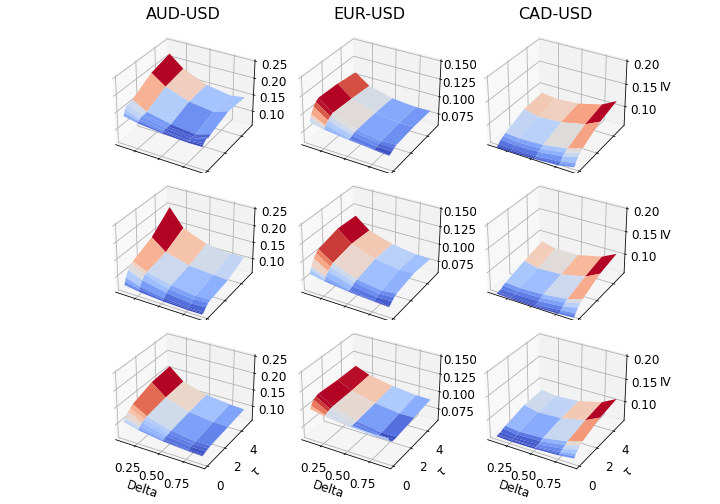

In [5]:
from matplotlib import cm
import matplotlib.gridspec as gridspec  

import matplotlib.pylab as pylab
params = {'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

fig, ax = plt.subplots(3,3,subplot_kw={"projection": "3d"}, figsize = (10, 7), gridspec_kw = {'wspace':0, 'hspace':-.07})
surf = ax[0,0].plot_surface(deltas, taus, AUD_surf[0], cmap=cm.coolwarm, linewidth=0)
surf = ax[0,1].plot_surface(deltas, taus, EUR_surf[0], cmap=cm.coolwarm, linewidth=0)
surf = ax[0,2].plot_surface(deltas, taus, CAD_surf[0], cmap=cm.coolwarm, linewidth=0)
ax[0,0].set_zlim(0.06, 0.25)
ax[0,1].set_zlim(0.06, 0.15)
ax[0,2].set_zlim(0.06, 0.20)
ax[0,0].set_title('AUD-USD',fontsize=16)
ax[0,1].set_title('EUR-USD',fontsize=16)
ax[0,2].set_title('CAD-USD',fontsize=16)

surf = ax[1,0].plot_surface(deltas, taus, AUD_surf[1], cmap=cm.coolwarm, linewidth=0)
surf = ax[1,1].plot_surface(deltas, taus, EUR_surf[1], cmap=cm.coolwarm, linewidth=0)
surf = ax[1,2].plot_surface(deltas, taus, CAD_surf[1], cmap=cm.coolwarm, linewidth=0)
ax[1,0].set_zlim(0.06, 0.25)
ax[1,1].set_zlim(0.06, 0.15)
ax[1,2].set_zlim(0.06, 0.20)

surf = ax[2,0].plot_surface(deltas, taus, AUD_surf[2], cmap=cm.coolwarm, linewidth=0)
surf = ax[2,1].plot_surface(deltas, taus, EUR_surf[2], cmap=cm.coolwarm, linewidth=0)
surf = ax[2,2].plot_surface(deltas, taus, CAD_surf[2], cmap=cm.coolwarm, linewidth=0)
ax[2,0].set_zlim(0.06, 0.25)
ax[2,1].set_zlim(0.06, 0.15)
ax[2,2].set_zlim(0.06, 0.20)

ax[2,0].set_ylabel(r'$\tau$')
ax[2,1].set_ylabel(r'$\tau$')
ax[2,2].set_ylabel(r'$\tau$')
ax[2,0].set_xlabel('Delta')
ax[2,1].set_xlabel('Delta')
ax[2,2].set_xlabel('Delta')

ax[0,2].set_zlabel('IV')
ax[1,2].set_zlabel('IV')
ax[2,2].set_zlabel('IV')

ax[0,0].set_yticklabels([])
ax[0,1].set_yticklabels([])
ax[0,2].set_yticklabels([])
ax[1,0].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])
ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])
ax[0,2].set_xticklabels([])
ax[1,0].set_xticklabels([])
ax[1,1].set_xticklabels([])
ax[1,2].set_xticklabels([])

plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)
plt.show()